# SBTB grade analysis
Do an overview of the data pulled, looking at grade distribution and genres for site and by reviewer.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3 as sql
import pprint

---

## Load data

In [2]:
# open database, import data into pandas
conn = sql.connect("sbtb.db")
df = pd.read_sql_query("SELECT * from Reviews;", conn)

print(df.head())

conn.close()

   Id Review_date                                               Link  \
0   1  2016-07-06  http://smartbitchestrashybooks.com/reviews/mak...   
1   2  2016-07-05  http://smartbitchestrashybooks.com/reviews/her...   
2   3  2016-06-30  http://smartbitchestrashybooks.com/reviews/ple...   
3   4  2016-06-28  http://smartbitchestrashybooks.com/reviews/all...   
4   5  2016-06-23  http://smartbitchestrashybooks.com/reviews/emi...   

        Reviewer Grade                     Title            Author  Pub_year  \
0          Elyse    C-          Make Me Love You   Johanna Lindsey    2016.0   
1       Carrie S    B+           Heroine Complex        Sarah Kuhn    2016.0   
2       SB Sarah    B-         Please Release Me      Rhoda Baxter    2015.0   
3  Redheadedgirl     A                    All In  Simona Ahrnstedt    2016.0   
4       SB Sarah    B+  Emily and the Dark Angel       Jo Beverley    1992.0   

                                           Genres  guest_review  \
0                  

---

## Plot reviewer distribution
Number of reviews by each unique reviewer

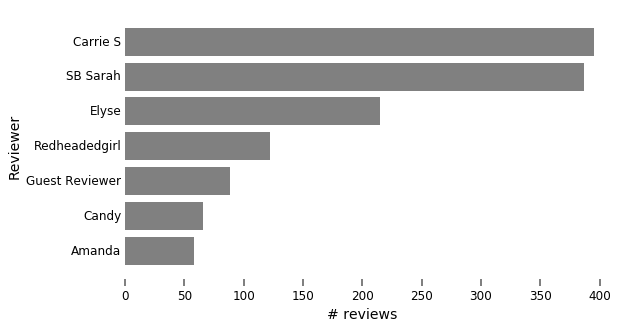

In [3]:
#print(df['Reviewer'].unique())
reviewers = df[['Reviewer','Id']]
reviewer_count = reviewers.groupby('Reviewer').count().sort_values('Id')
#print(reviewer_count)
#reviewer_count.sort_values(['Id']).plot(kind='barh',sort_columns=True,legend=False)

y_pos = np.arange(len(reviewer_count))

fig = plt.figure(figsize=(8.5, 5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)

ax.barh(y_pos, reviewer_count['Id'], align='center', color='grey', lw=0)
ax.set_yticks(y_pos)
ax.set_yticklabels(reviewer_count.index)

ax.set_xlabel('# reviews', size=14)
ax.set_ylabel('Reviewer', size=14)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(labelsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width=2, length=7, color='grey', labelsize=12)


plt.show()


---

## Rendering grades

For proper rendering of column names, grades should be converted to numbers. Make an inverted grade dictionary with ```-1``` set to 'Misc' for plotting ease. Saved in a new column ```grade_num```.

Let's use a 5 point scale +/- 0.3 for plus and minus.

In [4]:
#print(df.Grade.unique())
grade_dict = {
    'A+': 5.3,
    'A' : 5.0,
    'A-': 4.7,
    'B+': 4.3,
    'B' : 4.0,
    'B-': 3.7,
    'C+': 3.3,
    'C' : 3.0,
    'C-': 2.7,
    'D+': 2.3,
    'D' : 2.0,
    'D-': 1.7,
    'F+': 1.3,
    'F' : 1.0,
    'DNF' : 0.,
    'Rant' : -1,
    'Squee' : -1,
    'N/A' : -1
}

grade_dict_invert = {v: k for k, v in grade_dict.items()}
grade_dict_invert[-1] = 'Misc'

In [5]:
for grade in grade_dict:
    df.loc[df["Grade"] == grade,"grade_num"] = grade_dict[grade]

---

## Plot grade distribution
Full site, all reviews by all reviewers

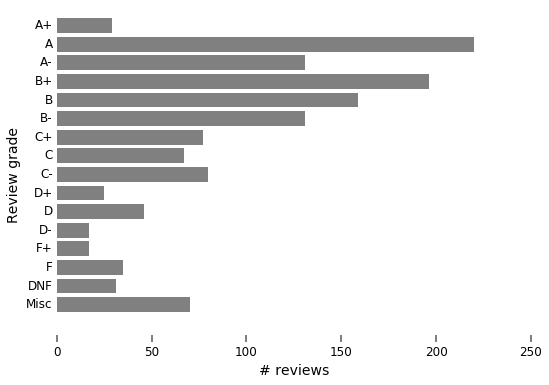

In [6]:
grades = df[['grade_num','Id']]
grades_count = grades.groupby('grade_num').count(); #print((grades_count['Id']))
#print(grades_count)
#grades_count.sort_values(['Id']).plot(kind='barh',legend=False,grid=True)

y_pos = np.arange(len(grades_count)); 
y_labels = [grade_dict_invert[k] for k in grades_count.index]
#print(y_labels)

fig = plt.figure(figsize=(8.5, 6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)

ax.barh(y_pos, grades_count['Id'], align='center', color='grey', lw=0)
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)

ax.set_xlabel('# reviews', size=14)
ax.set_ylabel('Review grade', size=14)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(labelsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width=2, length=7, color='grey', labelsize=12)
plt.show()


#grades_count.plot(kind='barh',legend=False,grid=True)

---

## Plot grade distribution by reviewer

Now we want to look at grade distributions for each reviewer. 
I would expect Guest Reviews are going to be bimodal (very positive or very negative).

In [7]:
def fill_grade_gaps(grade_df):
    # Want all possible grades, any not in dataframe will be set to zero
    if len(grade_df) == len(grade_dict_invert):
        return grade_df
    df_zeros = pd.DataFrame(0, index=sorted(list(grade_dict_invert.keys())), columns=['Id'])
    return grade_df.add(df_zeros, fill_value=0)

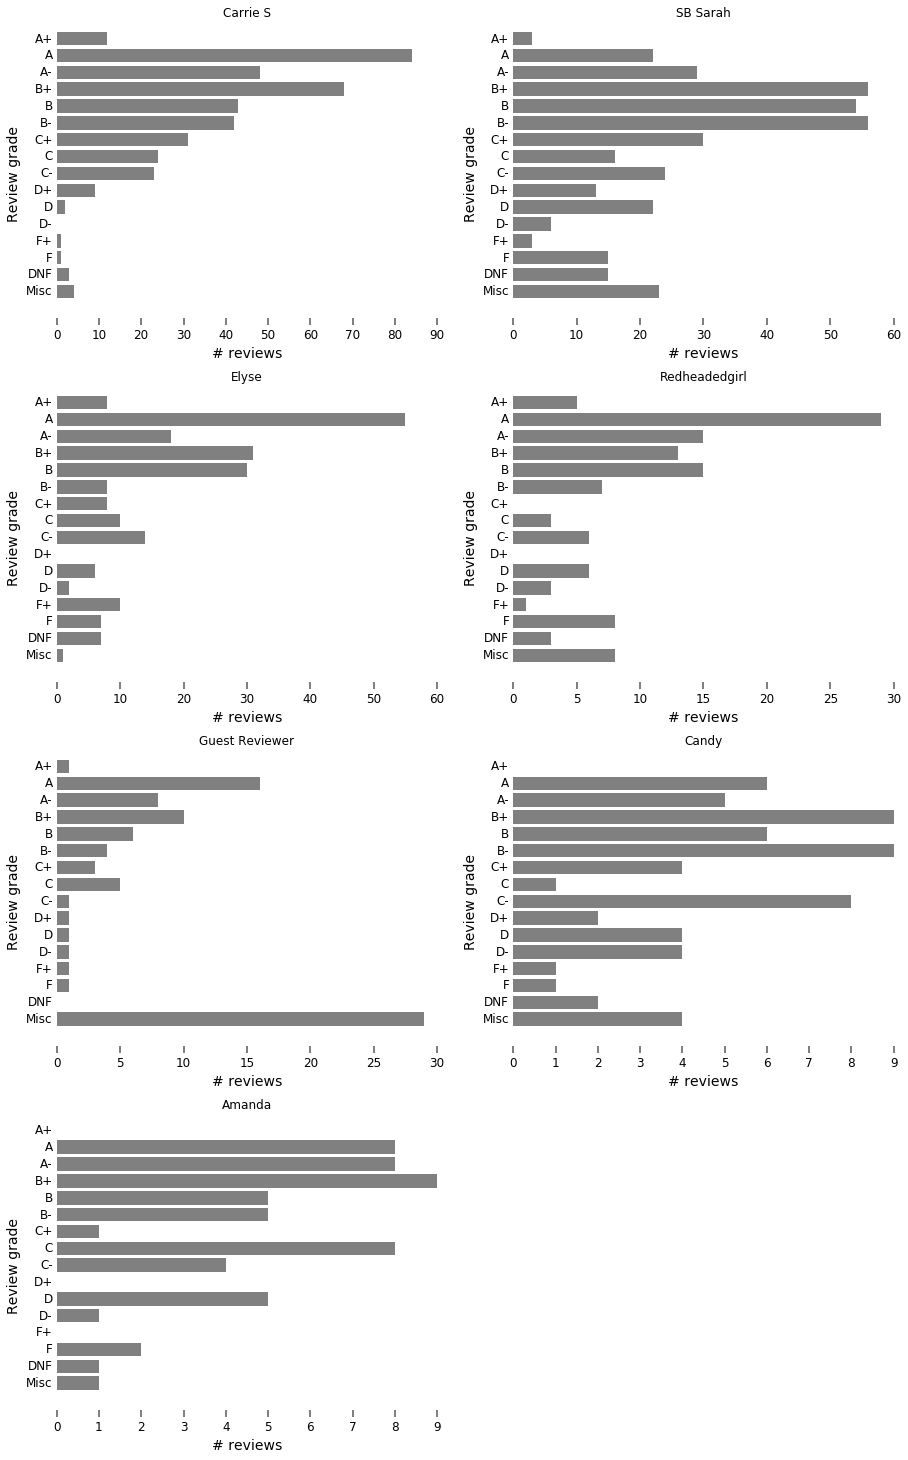

In [8]:
reviewers = df['Reviewer'].unique()

fig = plt.figure(figsize=(15,25))

for i, reviewer in enumerate(reviewer_count.index):
    #print(reviewer)
    grades = df[df['Reviewer']== reviewer]
    grades = grades[['grade_num','Id']]
    grades_count = grades.groupby('grade_num').count(); #print(grades_count)
    grades_count = fill_grade_gaps(grades_count)
    
    ax = fig.add_subplot(4,2,7-i)
    ax.set_frame_on(False)
    
    y_pos = np.arange(len(grades_count)); 
    ax.barh(y_pos, grades_count['Id'], align='center', color='grey', lw=0)
    
    ax.set_title(reviewer)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)

    ax.set_xlabel('# reviews', size=14)
    ax.set_ylabel('Review grade', size=14)

    ax.yaxis.set_ticks_position('none')
    ax.yaxis.set_tick_params(labelsize=12)

    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width=2, length=7, color='grey', labelsize=12)

    
    
    
    #grades_count.plot(kind='bar',legend=False,grid=True,title=reviewer)
    
plt.show()

---

## Calculate the review GPA

Ignore any of the "Miscellaneous" category entries, mostly those are "Rant" and "Squee" reviews. It's like an audit. 

This calculation could be put into the title of the above bar charts.

In [9]:
for i, reviewer in enumerate(reviewer_count.index):
    grades = df[(df['Reviewer']==reviewer) & (df['grade_num']>-1)]['grade_num']
    print('{} GPA: {:.2f}'.format(reviewer, grades.sum()/grades.count()))

Amanda GPA: 3.62
Candy GPA: 3.37
Guest Reviewer GPA: 4.08
Redheadedgirl GPA: 3.82
Elyse GPA: 3.81
SB Sarah GPA: 3.41
Carrie S GPA: 4.07


---

## Find top genres reviewed

I believe "Romance" might be one of those genres, so that might need to be kicked out if it's the top genre for all reviewers. There might be issues with how genres were done in the past versus now.

Multi-genre books have genres separated by semicolons. First, let's do the whole site, then by reviewer. Looping does not feel like the ideal, but the multi-genre thing is a killer.

Let's only look at graded reviews, so those not assigned a "miscellaneous" grade.

In [10]:
genresdb = df[df['grade_num'] > -1]['Genres']; print("Total reviews: {}\n".format(genresdb.count()))
genres = {}
for genre in genresdb:
    genre_list = [g.strip() for g in genre.split(';')]
    for g in genre_list:
        genres.setdefault(g, 0)
        genres[g] += 1
        
pprint.pprint(genres)

Total reviews: 1261

{'Anthology': 2,
 'Art': 2,
 'Chick Lit': 13,
 'Classic': 19,
 'Comic': 26,
 'Contemporary Romance': 274,
 'Contemporary/Other': 10,
 'Cookbook': 11,
 'Erotica/Erotic Romance': 60,
 'Fantasy/Fairy Tale Romance': 12,
 'GLBT': 45,
 'Gothic': 3,
 'Graphic Novel': 18,
 'Historical': 165,
 'Historical: American': 26,
 'Historical: European': 137,
 'Historical: Other': 14,
 'Horror': 17,
 'Humor': 10,
 'Inspirational': 1,
 'Literary Fiction': 27,
 'Memoir': 10,
 'Middle Grade': 1,
 'Mystery/Thriller': 47,
 'New Adult': 19,
 'Nonfiction': 86,
 'Not a Book': 1,
 'Novella': 28,
 'Paranormal': 84,
 'Regency': 41,
 'Romance': 362,
 'Romantic Suspense': 41,
 'Science Fiction/Fantasy': 215,
 'Steampunk': 15,
 'Teen Fiction': 2,
 'Time Travel': 13,
 'Top 100 Banned Books': 21,
 'Urban Fantasy': 22,
 'Western': 1,
 "Women's Fiction": 13,
 'Young Adult': 76}


---

## Find top 5 genres for each reviewer

In [11]:
for i, reviewer in enumerate(reviewer_count.index):
    genresdb = df[(df['Reviewer']==reviewer) & (df['grade_num'] > -1)]['Genres']; 
    
    print("\nReviewer: {}".format(reviewer))
    
    genres = {}
    for genre in genresdb:
        genre_list = [g.strip() for g in genre.split(';')]
        for g in genre_list:
            genres.setdefault(g, 0)
            genres[g] += 1
    reviewer_genres = pd.DataFrame.from_dict(genres, orient='index').rename(columns={0:'count'})
    pprint.pprint(reviewer_genres.sort_values(by='count', ascending=False)[:5])


Reviewer: Amanda
                         count
Romance                     34
Contemporary Romance        22
Erotica/Erotic Romance      12
Paranormal                   6
Science Fiction/Fantasy      5

Reviewer: Candy
                         count
Historical                  23
Science Fiction/Fantasy     10
Contemporary Romance        10
Paranormal                   8
Literary Fiction             3

Reviewer: Guest Reviewer
                        count
Romance                    23
Contemporary Romance       19
Historical                  9
Erotica/Erotic Romance      6
GLBT                        6

Reviewer: Redheadedgirl
                      count
Romance                  52
Historical: European     32
Historical               27
Contemporary Romance     13
Nonfiction                8

Reviewer: Elyse
                      count
Romance                 114
Contemporary Romance     54
Historical: European     43
Romantic Suspense        26
Mystery/Thriller         24

Reviewer